##**Importar librerías y cargar archivos csv**

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

In [144]:
# Cargar archivos csv
def load_dataframes():
    df_clientes = pd.read_csv("clientes.csv")
    df_solicitudes_credito = pd.read_csv("solicitudes_credito.csv")
    df_evaluaciones_riesgo = pd.read_csv("evaluaciones_riesgo.csv")
    df_pagos = pd.read_csv("pagos.csv")
    df_historial_crediticio = pd.read_csv("historial_crediticio.csv")
    print("Se cargaron las tablas desde archivos CSV.")
    return df_clientes, df_solicitudes_credito, df_evaluaciones_riesgo, df_pagos, df_historial_crediticio


df_clientes, df_solicitudes_credito, df_evaluaciones_riesgo, df_pagos, df_historial_crediticio = load_dataframes()

Se cargaron las tablas desde archivos CSV.


## **Análisis de datos exploratorio**

In [145]:
#Exploración de datos
def explore_dataframe(df, nombre_tabla):
    print(f"\n{'-'*50}\nEXPLORACIÓN DE {nombre_tabla}\n{'-'*50}")
    print("Primeras filas:")
    print(df.head()) #Visualización de las primeras filas
    print("\nInformación del dataframe:")
    print(df.info()) #Resume los tipos de datos
    print("\nDescripción estadística:")
    print(df.describe()) #Muestra estadísticas descriptivas
    print("\nValores faltantes:")
    print(df.isnull().sum()) #Conteo de valores nulos
    print("\nValores duplicados:")
    print(df.duplicated().sum()) #Conteo de valores duplicados
    print("\nValores únicos por columna:")
    print(df.nunique()) #Conteo de valores únicos
    print("\nDistribución de valores en columnas categóricas:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"\nDistribución de {col}:")
        print(df[col].value_counts())
    print("\nDistribución de valores en columnas numéricas:")
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        print(f"\nDistribución de {col}:")
        print(df[col].value_counts())

dataframes = {
    'Clientes': df_clientes,
    'Solicitudes de Crédito': df_solicitudes_credito,
    'Evaluaciones de Riesgo': df_evaluaciones_riesgo,
    'Pagos': df_pagos,
    'Historial crediticio': df_historial_crediticio
}

for nombre_tabla, df in dataframes.items():
    explore_dataframe(df, nombre_tabla)


--------------------------------------------------
EXPLORACIÓN DE Clientes
--------------------------------------------------
Primeras filas:
   id_cliente sexo fecha_nacimiento  ingreso_mensual
0           1    M       1979-06-04             6762
1           2    F       1978-12-25             9936
2           3    M       1990-07-18             7210
3           4    M       1979-01-08             7565
4           5    F       1998-09-17             8388

Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_cliente        200 non-null    int64 
 1   sexo              200 non-null    object
 2   fecha_nacimiento  200 non-null    object
 3   ingreso_mensual   200 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.4+ KB
None

Descripción estadística:
       id_cliente  ingreso_mensual
count  200.0000

## **Observaciones preliminares**
---
*   Relación entre score de riesgo y estado de créditos.

*   Análisis de ingresos vs tasas de interés aprobadas.

*   Impacto del historial crediticio en la aprobación de créditos

> Predecir si una solicitud será aprobada o rechazada según características del cliente y del crédito.

> Identificar y analizar qué variables influyen en la decisión de aprobación.



## **Preparación de datos**


In [146]:
# Transformar de variables categóricas a numéricas
label_encoders = {}
categorical_cols = ['sexo','nivel_riesgo','estado_creditos','historial_crediticio','historial_pagos']
for col in categorical_cols:
    le = LabelEncoder()
    for df_name, df in dataframes.items():
      if col in df.columns:
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

##**Nota**
---

**estado_creditos**

---
Aprobado: 0,
Rechazado: 2,
Pendiente: 1


**nivel_riesgo**

---
Bajo: 1,
Medio: 2,
Alto: 0

*En esta oportunidad no hay valores nulos. Caso contrario, estos se imputan con la media u otra metodología.*

## **Unión de tablas para análisis**

In [147]:
# Unión de tablas en un solo dataset
df = df_clientes.merge(df_solicitudes_credito, on="id_cliente", how="inner") \
             .merge(df_evaluaciones_riesgo, on="id_solicitud", how="inner") \
             .merge(df_historial_crediticio, on="id_cliente", how="left")

# Eliminar columnas irrelevantes
df.drop(columns=['fecha_nacimiento', 'comentarios', 'id_solicitud', 'id_cliente', 'id_historial', 'id_evaluacion'], inplace=True)

# Mostrar la estructura del dataset consolidado
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sexo                200 non-null    int64  
 1   ingreso_mensual     200 non-null    int64  
 2   monto_solicitado    200 non-null    float64
 3   plazo_meses         200 non-null    int64  
 4   tasa_interes        200 non-null    float64
 5   score_riesgo        200 non-null    int64  
 6   nivel_riesgo        200 non-null    int64  
 7   estado_creditos     200 non-null    int64  
 8   monto_total         200 non-null    float64
 9   cantidad_prestamos  200 non-null    int64  
 10  historial_pagos     200 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 17.3 KB


(None,
    sexo  ingreso_mensual  monto_solicitado  plazo_meses  tasa_interes  \
 0     1             6762          31860.39           24          3.99   
 1     0             9936           1161.04           48          3.50   
 2     1             7210          25256.21           12          3.50   
 3     1             7565           9460.44           60          7.68   
 4     0             8388          19472.16           60         12.04   
 
    score_riesgo  nivel_riesgo  estado_creditos  monto_total  \
 0           705             2                0     92470.94   
 1           896             1                1     11570.59   
 2           732             2                0     54676.47   
 3           753             1                0     17326.77   
 4           803             1                0     50906.84   
 
    cantidad_prestamos  historial_pagos  
 0                   2                0  
 1                   4                2  
 2                   3             

## **Planteamiento preliminar de modelos de aprendizaje automático**
- Aplicar modelos de **árbol de decisión** para clasificar clientes en niveles de riesgo.
- Probar **regresión logística** para predecir la aprobación de créditos.

## **Modelo 1: Árbol de decisión para clasificar clientes en niveles de riesgo**

### **Nota**
---
* gini: mide la pureza del nodo (cercano a 0 significa que la mayoría de los datos pertenecen a una sola clase).

* samples: cantidad de muestras en ese nodo.

* value: cantidad de registros por clase en ese nodo.

* class: categoría asignada al nodo (Bajo = 1, Medio = 2, Alto = 0).


Árbol de Decisión para Nivel de Riesgo - Accuracy: 0.975
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        10
           2       0.96      1.00      0.98        22

    accuracy                           0.97        40
   macro avg       0.99      0.96      0.97        40
weighted avg       0.98      0.97      0.97        40



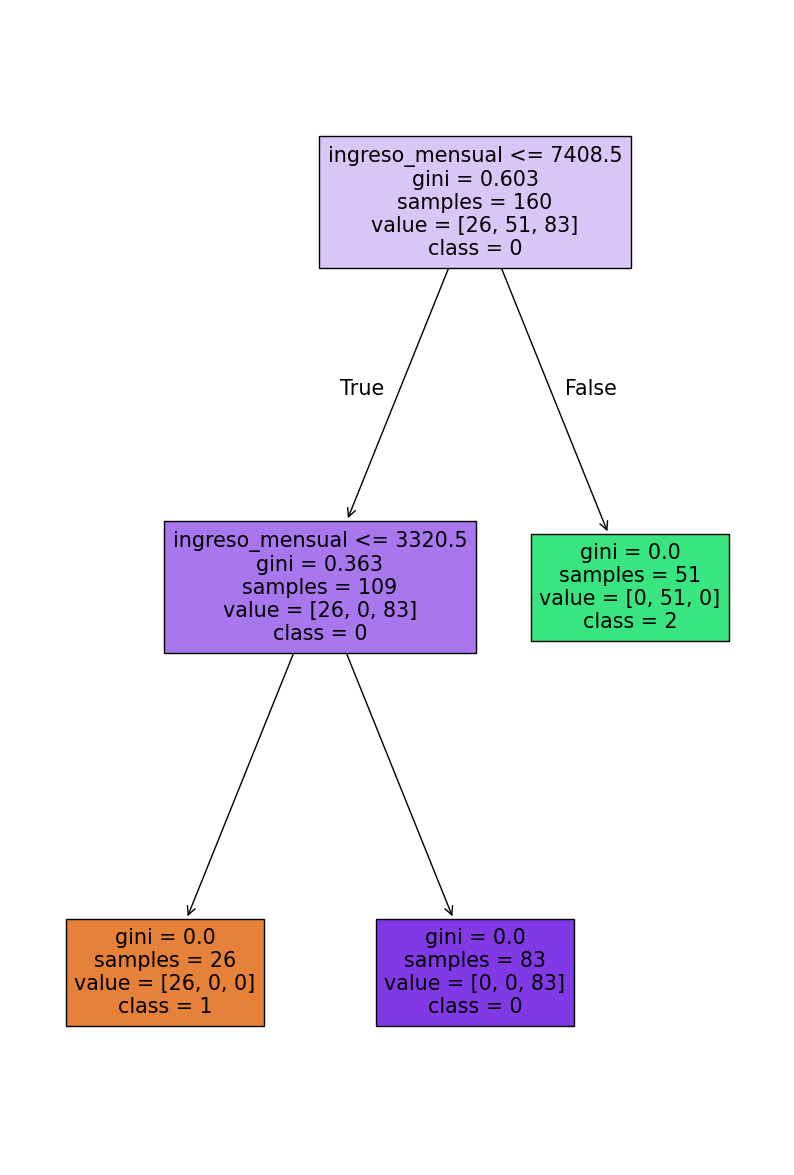

In [148]:
# Visualización del árbol de decisión para clasificar nivel de riesgo
X_risk = df[['ingreso_mensual','monto_solicitado','cantidad_prestamos','plazo_meses', 'tasa_interes', 'historial_pagos']]
y_risk = df['nivel_riesgo']

X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split = 5, random_state=42)
decision_tree.fit(X_train_risk, y_train_risk)
y_pred_risk = decision_tree.predict(X_test_risk)
print("\nÁrbol de Decisión para Nivel de Riesgo - Accuracy:", accuracy_score(y_test_risk, y_pred_risk))
print(classification_report(y_test_risk, y_pred_risk))

plt.figure(figsize=(10, 15))
plot_tree(decision_tree, feature_names=X_risk.columns, class_names=['1', '2', '0'], filled=True)
plt.show()

ingreso_mensual: 1.0000
monto_solicitado: 0.0000
cantidad_prestamos: 0.0000
plazo_meses: 0.0000
tasa_interes: 0.0000
historial_pagos: 0.0000


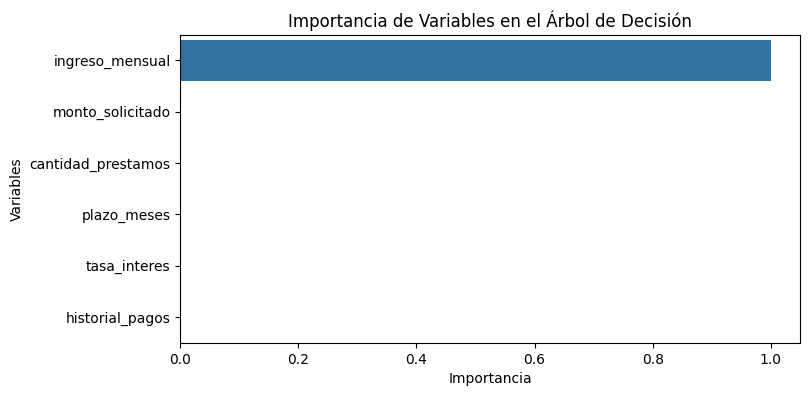

In [149]:
importances = decision_tree.feature_importances_
feature_names = X_risk.columns

# Mostrar importancia de las variables
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Visualización de importancia de variables
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de Variables en el Árbol de Decisión")
plt.show()

### **1.1 Modelo de algoritmo de regresión: Árbol de decisión**


Evaluación del Árbol de Decisión para Score de Riesgo:
MAE: 16.30488553113553
MSE: 377.71472811338515
R2 Score: 0.9807786436965885


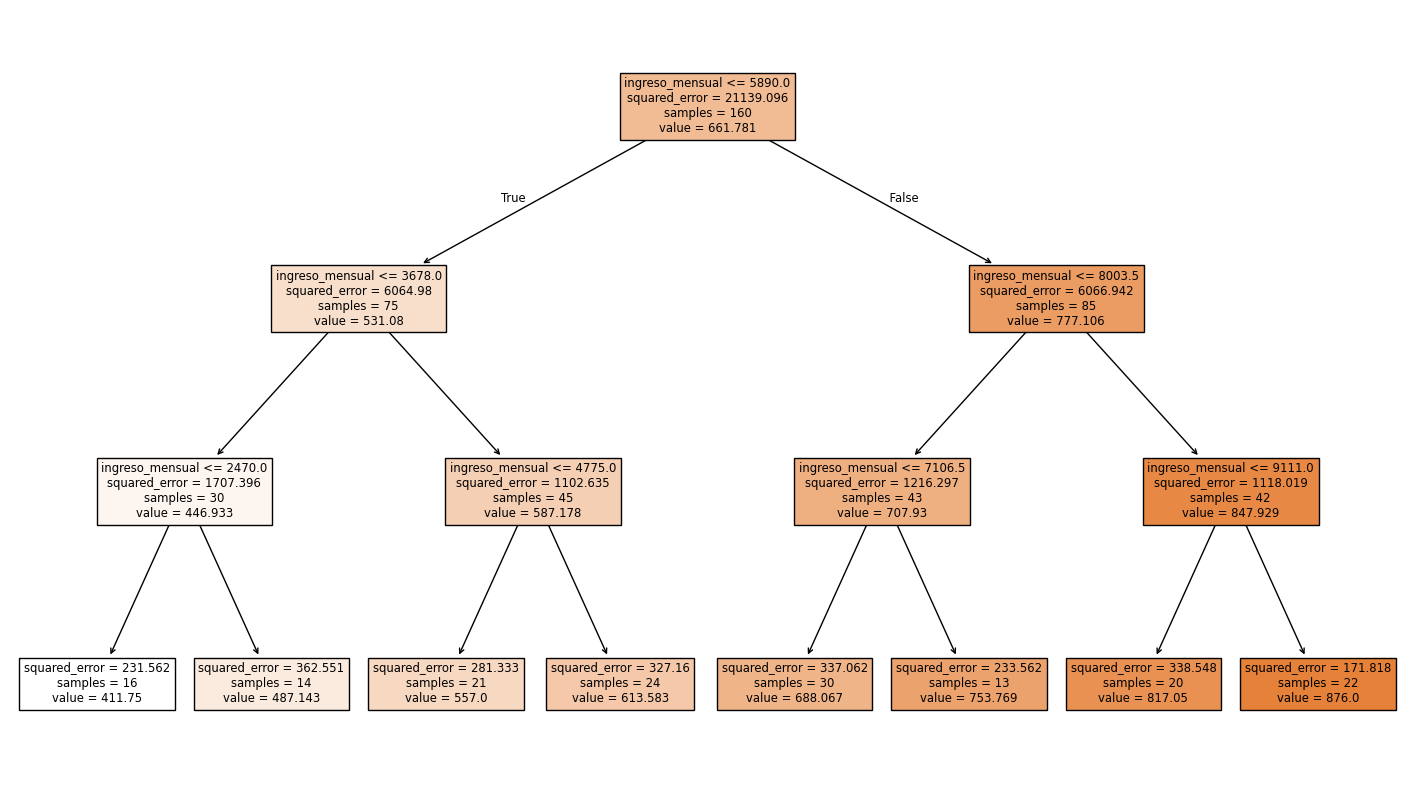

In [150]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_risk = df[['ingreso_mensual', 'monto_solicitado','plazo_meses']]
y_risk = df['score_riesgo']

X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

# Modelo de Árbol de Decisión para regresión
decision_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
decision_tree.fit(X_train_risk, y_train_risk)
y_pred_risk = decision_tree.predict(X_test_risk)

print("\nEvaluación del Árbol de Decisión para Score de Riesgo:")
print(f"MAE: {mean_absolute_error(y_test_risk, y_pred_risk)}")
print(f"MSE: {mean_squared_error(y_test_risk, y_pred_risk)}")
print(f"R2 Score: {r2_score(y_test_risk, y_pred_risk)}")

plt.figure(figsize=(18, 10))
plot_tree(decision_tree, feature_names=X_risk.columns, filled=True)
plt.show()


ingreso_mensual: 1.0000
monto_solicitado: 0.0000
plazo_meses: 0.0000


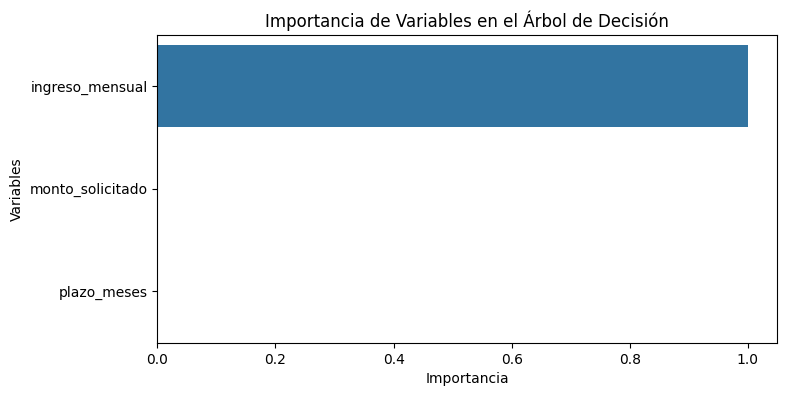

In [151]:
importances = decision_tree.feature_importances_
feature_names = X_risk.columns

# Mostrar importancia de las variables
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Visualización de importancia de variables
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de Variables en el Árbol de Decisión")
plt.show()

### **1.2 Modelo de algoritmo de clasificación: Random Forest**


Random Forest para Nivel de Riesgo - Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00        10
           2       0.95      0.91      0.93        22

    accuracy                           0.93        40
   macro avg       0.91      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40

ingreso_mensual: 0.8140
monto_solicitado: 0.1860


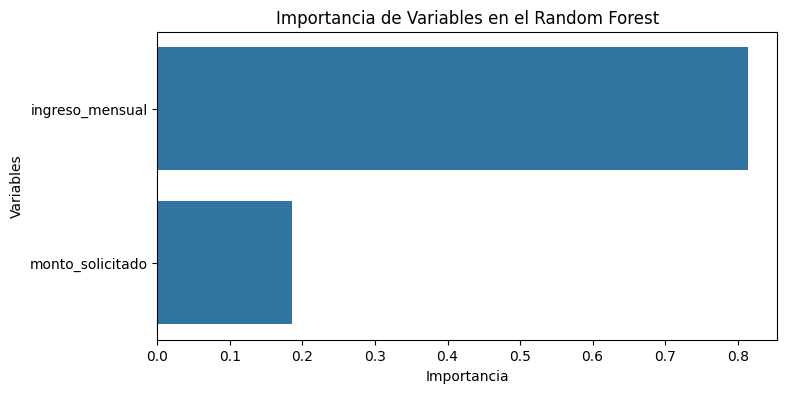

In [153]:
# Definir variables predictoras y objetivo
X_risk = df[['ingreso_mensual', 'monto_solicitado']]
y_risk = df['nivel_riesgo']

# División en entrenamiento y prueba
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train_risk, y_train_risk)

# Hacer predicciones
y_pred_risk = rf_model.predict(X_test_risk)

# Evaluar el rendimiento
print("\nRandom Forest para Nivel de Riesgo - Accuracy:", accuracy_score(y_test_risk, y_pred_risk))
print(classification_report(y_test_risk, y_pred_risk))

# Importancia de las características
feature_names = X_risk.columns
importances = rf_model.feature_importances_
for feature, importance in zip(X_risk.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Visualización de importancia de variables
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de Variables en el Random Forest")
plt.show()

## **Modelo 2: Regresión logística**

In [154]:
# Normalización de variables numéricas (escalar)
scaler = MinMaxScaler()
numeric_cols = ['ingreso_mensual','tasa_interes','plazo_meses','monto_total','score_riesgo','monto_pagado','cantidad_prestamos']

for df_name, df_obj in dataframes.items():
    existing_cols = [col for col in numeric_cols if col in df_obj.columns]
    df_obj[existing_cols] = scaler.fit_transform(df_obj[existing_cols])

## **Visualización de datos**

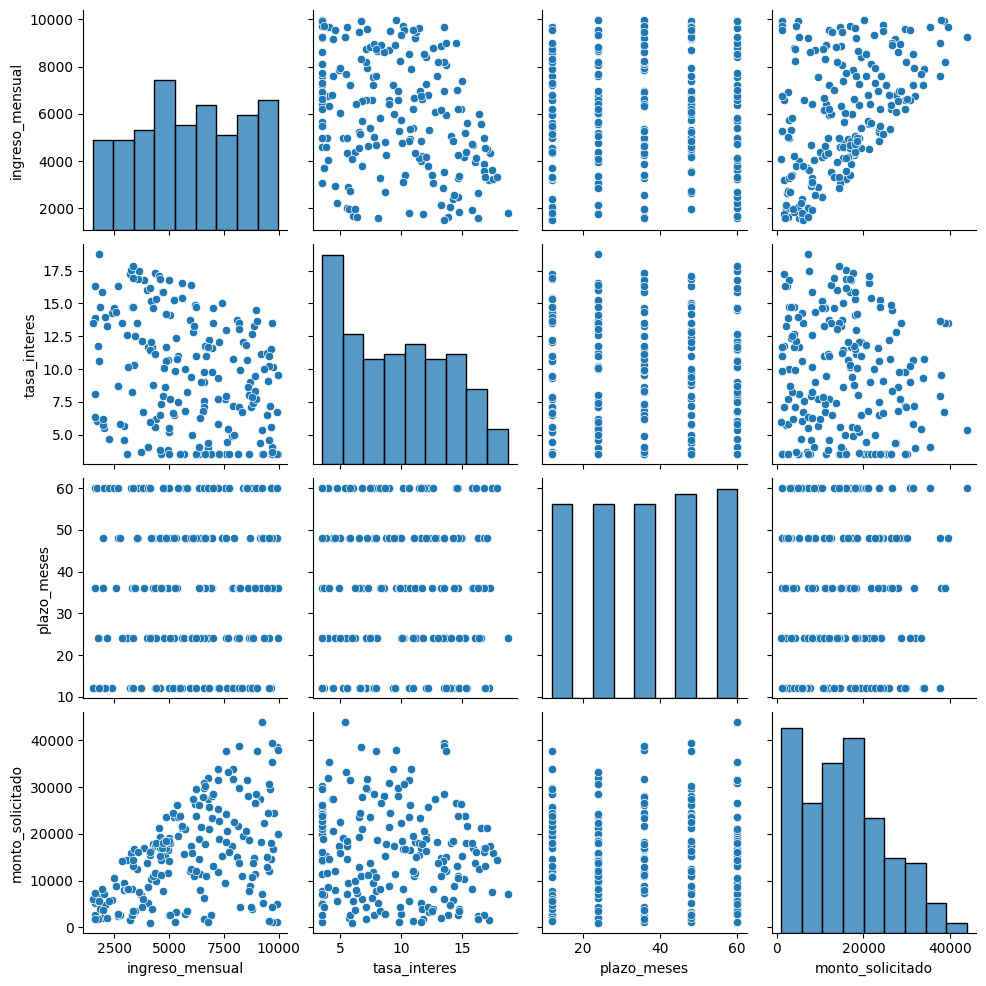

In [155]:
#Pairplot 1
sns.pairplot(df[['ingreso_mensual', 'tasa_interes','plazo_meses','monto_solicitado']])
plt.show()

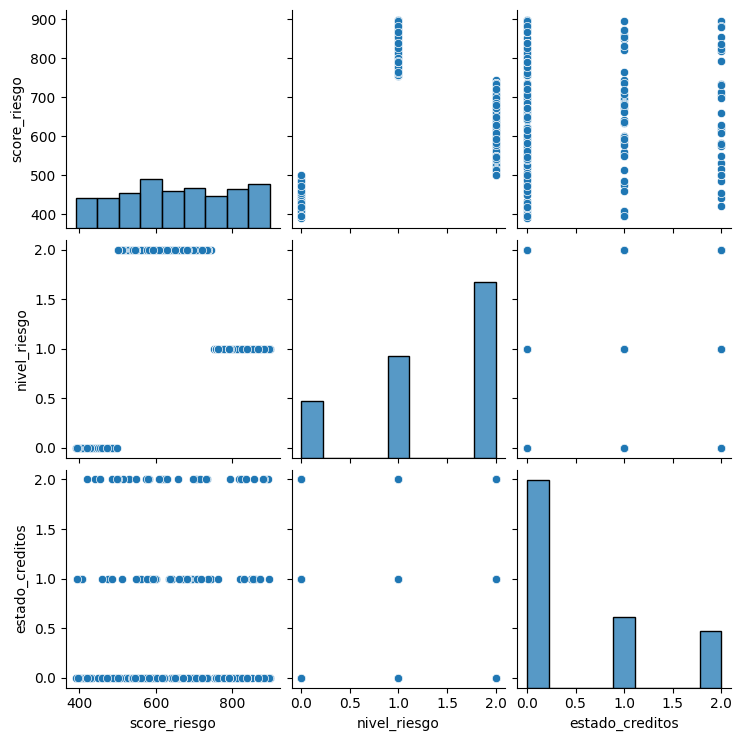

In [156]:
# Pairplot 2
sns.pairplot(df[['score_riesgo','nivel_riesgo','estado_creditos']])
plt.show()

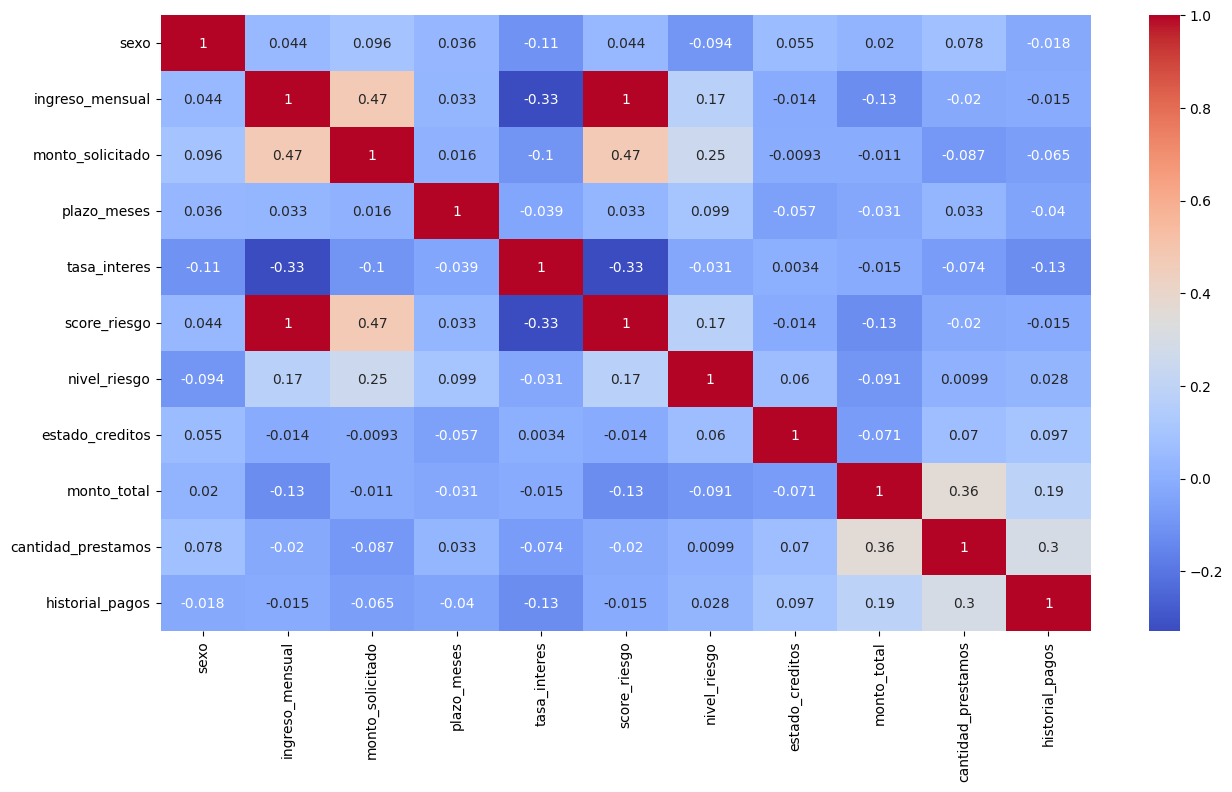

In [157]:
# Heatmap de correlación
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## **Resultados**

> **Correlación entre "ingreso_mensual" y "monto_solicitado" (0.47)**
 - Esto tiene sentido, ya que clientes con ingresos más altos tienden a solicitar montos mayores.

> **El "score_riesgo" está fuertemente correlacionado con "ingreso_mensual" y; moderadamente con "monto_solicitado" (0.47)**
 - Indica que personas con mayores ingresos y montos solicitados pueden tener un impacto en su score de riesgo.

> **"tasa_interes" tiene una correlación negativa con "ingreso_mensual" (-0.33)**
 - Sugiere que clientes con ingresos más altos suelen obtener tasas más bajas, lo que es esperable en términos de evaluación de riesgo.

>**Baja correlación entre "nivel_riesgo" y otras variables**
 - Puede ser que el nivel de riesgo no dependa de una sola variable, sino de una combinación más compleja de factores.

>**"cantidad_prestamos" tiene una correlación positiva con "monto_total" (0.36) e "historial_pagos" (0.3)**
 - Es lógico, más préstamos acumulados llevan a un mayor monto total de deuda y a un historial de pagos más extenso.

### **1. Seleccionar las variables predictoras (X) y la variable objetivo (y)**

In [158]:
# Filtrar solo los datos de estado_creditos que sean 0 (Aprobado) o 2 (Rechazado)
df = df[df['estado_creditos'].isin([0, 2])]

In [159]:
# Seleccionar las variables predictoras y variable objetivo
X = df[['monto_total', 'cantidad_prestamos', 'historial_pagos']]
y = df['estado_creditos'] # Variable objetivo (0 = Aprobado, 2 = Rechazado)

### **2. Transformar temporalmente la variable objetivo (0 → 0, 2 → 1)**

In [160]:
y_temp = y.replace({2: 1})  # Ahora tenemos 0 (Aprobado) y 1 (Rechazado)

### **3: Dividir en conjunto de entrenamiento y prueba**

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y_temp, test_size=0.2, random_state=42)

### **4. Entrenar modelo**

In [161]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

### **5. Hacer predicciones**

In [162]:
y_pred_temp = log_reg.predict(X_test)

### **6. Volver a convertir las predicciones al formato original (0 → 0, 1 → 2)**

In [163]:
y_pred = pd.Series(y_pred_temp).replace({1: 2})

### **7. Evaluar el modelo**

In [164]:
print("Accuracy:", accuracy_score(y_test.replace({1: 2}), y_pred))  # Convertimos y_test de vuelta
print(classification_report(y_test.replace({1: 2}), y_pred))

Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.64      0.95      0.77        19
           2       0.50      0.09      0.15        11

    accuracy                           0.63        30
   macro avg       0.57      0.52      0.46        30
weighted avg       0.59      0.63      0.54        30



## **Clase 0 (Aprobado):**

- Precisión del 64% → Cuando predice "Aprobado", acierta el 64% de las veces.
- Recall del 95% → Detecta la mayoría de los créditos aprobados.
- F1-score del 77% → Buen balance entre precisión y recall.

## **Clase 2 (Rechazado):**

- Precisión del 50% → Acierta la mitad de veces al predecir "Rechazado".
- Recall del 9% → Detecta el 9% de los créditos rechazados.
- F1-score del 15% → Desbalance entre precisión y recall.

##**Diagnóstico del desbalance de clases y entrenamiento de otros modelos de clasificación**

El desbalance de clases ocurre cuando una clase está representada con muchas más observaciones que la otra(s). En problemas de clasificación binaria, esto se da cuando una clase tiene un número significativamente mayor de muestras que la otra.

**Estrategias para Manejar el Desbalance**

**Técnicas de Resampling:**

* Oversampling: Aumentar la clase minoritaria (SMOTE, ADASYN).
* Undersampling: Reducir la clase mayoritaria.
* Asignar Ponderaciones a la Clase Minoritaria:
En modelos como Random Forest y XGBoost, se pueden usar class_weight o scale_pos_weight.
* Ajuste de Umbrales de Predicción:
Ajustar el umbral de probabilidad en lugar de usar 0.5.
* Modelos diseñados para desbalance:
Algunos algoritmos como XGBoost tienen hiperparámetros que pueden ajustarse para mejorar la clasificación en conjuntos desbalanceados.


In [165]:
# Revisión de distribución de clases
df['estado_creditos'].value_counts(normalize=True)

,proportion
estado_creditos,
0,0.78481
2,0.21519


In [166]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y_temp)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Evaluación de múltiples modelos
models = {
    'Regresión Logística': LogisticRegression(),
    'Árbol de Decisión': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

# Optimización de hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20], # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nMejor configuración de Random Forest:")
print(grid_search.best_params_)
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print("\nResultados del mejor Random Forest:")
print(classification_report(y_test, y_pred_optimized))


Regresión Logística - Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.64      0.95      0.77        19
           1       0.50      0.09      0.15        11

    accuracy                           0.63        30
   macro avg       0.57      0.52      0.46        30
weighted avg       0.59      0.63      0.54        30


Árbol de Decisión - Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        19
           1       0.50      0.45      0.48        11

    accuracy                           0.63        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.63      0.63      0.63        30


Random Forest - Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        19
           1       0.50      0.55      0.52        11

    accuracy                      

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost - Accuracy: 0.43333333333333335
              precision    recall  f1-score   support

           0       0.55      0.58      0.56        19
           1       0.20      0.18      0.19        11

    accuracy                           0.43        30
   macro avg       0.38      0.38      0.38        30
weighted avg       0.42      0.43      0.43        30


Mejor configuración de Random Forest:
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}

Resultados del mejor Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        19
           1       0.56      0.45      0.50        11

    accuracy                           0.67        30
   macro avg       0.63      0.62      0.62        30
weighted avg       0.66      0.67      0.66        30



El mejor modelo de clasificación para
predecir la aprobación de créditos fue el algoritmo de bosque aleatorio con un accuracy del 67%